# <font color = 'darkblue'>**Finetuning with DistilRoBERTA base model**
I will be following a standard model training plan using the huggingface library and WANDB to track my experiment.
- The idea is to use the base DistilRoBERTa model to compare how well it does in comparison to the last models I have trained (RNN, RoBERTA, DistilBERT)
- Past instances of using class weights within the pretrained models have not resulted in much success but I will try again in this model with a different type of implementation.

**Training Plan**
- Set the Environment
- Load the dataset
- maniupulate the splits of the dataset
  - Multilabel Stratified KFold
  - Calculate class weights and use a scale factor
- Load the pretrained distilRoBERTa tokenizer
- Train the model
  - Download the model
  - Download and modify the model's config file.
  - Compute the metric function (ensuring we account for multilabel)(BCE)
  - Training Args
  - Instantiate the trainer
  - Setup WANDB
  - Training and Validation
- Model inference


# <font color = 'darkblue'>**Setting up the environment**

In [ ]:
import sys
if 'google.colab' in str(get_ipython()):  # If the code is running in Colab
    # mount google drive
    from google.colab import drive
    drive.mount('/content/drive')
        # set the base path to a Google Drive folder
    base_path = '/content/drive/MyDrive/Colab Notebooks'
        # Installing the latest torchinfo library
    !pip install torchtext -qq
    !pip install transformers evaluate wandb datasets accelerate  -U -qq
    !pip install iterative-stratification -qq


    #sys.path.append('/content/drive/MyDrive/Colab Notebooks/custom-functions')# enabling custom function usage

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<font color = 'darkblue'>***Loading Libraries***

In [ ]:
# Standard Datascience libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score
from pathlib import Path
import numpy as np

from sklearn.preprocessing import MultiLabelBinarizer
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
import joblib

# Huggingface, wandb, torch etc
import evaluate
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel
from transformers import AutoTokenizer, Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoConfig, pipeline
import wandb
from google.colab import userdata
from huggingface_hub import login
import torch.nn as nn
import ast
import torch


In [ ]:
wandb_api_key = userdata.get('WANDB_API_KEY')
hf_token = userdata.get('HF_TOKEN')


In [ ]:
if hf_token:
  login(token = hf_token)
  print('Login Successful')
else:
  print('HF login not unsuccessful - Missing token')


The token has not been saved to the git credentials helper. Pass `add_to_git_credential=True` in this function directly or `--add-to-git-credential` if using via `huggingface-cli` if you want to set the git credential as well.
Token is valid (permission: fineGrained).
Your token has been saved to /root/.cache/huggingface/token
Login successful
Login Successful


In [ ]:
if wandb_api_key:
  wandb.login(key = wandb_api_key)
  print('Login Successful')
else:
  print('Login Unsuccessful')

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Login Successful


In [ ]:
# Designating paths for saving and loading
base_folder = Path(base_path)
data_folder = base_folder/'datasets/emotion_detection_ds'
model_folder = base_folder/'models/nlp_fall_2024/distilroberta'


# <font color = 'darkblue'>**Loading the dataset**



In [ ]:
# Loading the original data for understanding
train_valid_df = pd.read_csv(data_folder/'train.csv') # Data before my split in RNN model ipynb
train_valid_df.head(5)

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [ ]:
train_val_labels = train_valid_df[['anger',
                                      'anticipation',
                                             'disgust',
                                             'fear',
                                             'joy',
                                             'love',
                                             'optimism',
                                             'pessimism',
                                             'sadness',
                                             'surprise',
                                             'trust']]

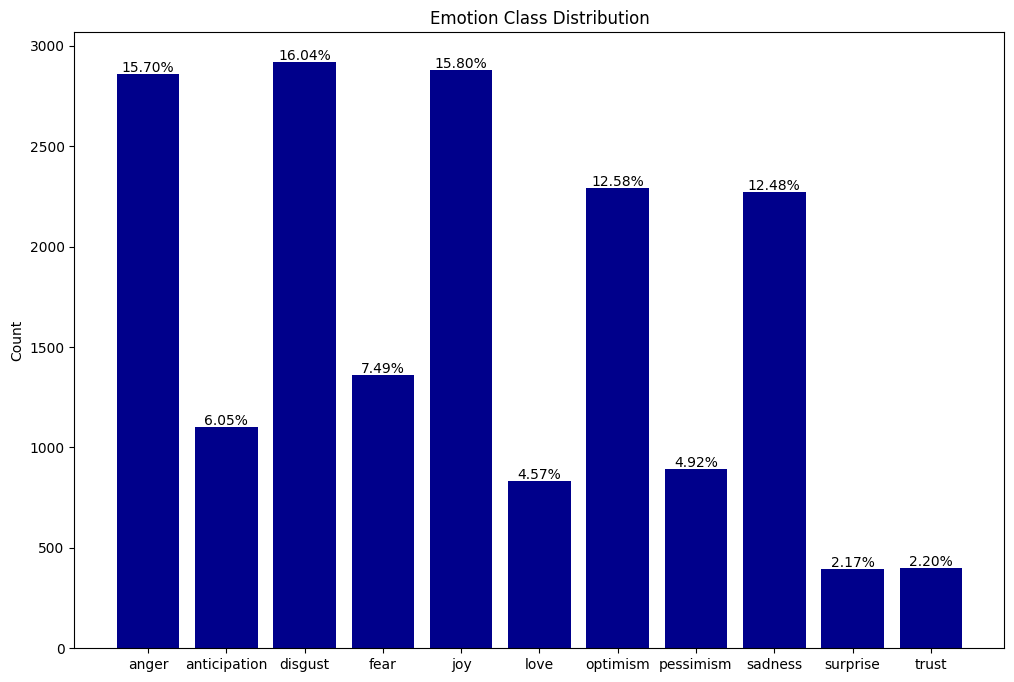

In [ ]:
# plotting of class distribution
label_counts = train_val_labels.sum()

# Total label counts
total_counts = label_counts.sum()

# percentage calculations
percentages = (label_counts/total_counts)*100

# Making a bar plot
plt.figure(figsize = (12,8))
plt.bar(label_counts.index, label_counts.values, color = 'darkblue')

# Adding labels for the percentages
for i, (count, pct) in enumerate(zip(label_counts.values, percentages)):
  plt.text(i, count + 10 , f'{pct:.2f}%',  ha = 'center' )


plt.title('Emotion Class Distribution')
plt.ylabel('Count')
plt.show()

In [ ]:
label_counts

,0
anger,2859
anticipation,1102
disgust,2921
fear,1363
joy,2877
love,832
optimism,2291
pessimism,895
sadness,2273
surprise,396


## <font color = 'darkblue'>**Manipulating Splits**
- For this model I plan on using the MultiLabelStratifiedKFold from the iterstrat library since it gave me the best results so far for my data splitting
- Last time I did 5 splits, this time I will be using 10 splits.

In [ ]:
# Instantiate the splitter
mkf = MultilabelStratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

X = train_valid_df['Tweet'].values
y = train_valid_df[['anger', 'anticipation', 'disgust', 'fear', 'joy', 'love',
        'optimism', 'pessimism', 'sadness', 'surprise', 'trust']].values

for train_index, val_index in mkf.split(X, y):
  X_train, X_val = X[train_index], X[val_index]
  y_train, y_val = y[train_index], y[val_index]


In [ ]:
# Reformatting things to dataframe
train_df = train_valid_df.iloc[train_index] # pulling the indices from the split that are designated as train
val_df = train_valid_df.iloc[val_index] # pulling the indices from the split that are designated as validation


In [ ]:
train_df.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
0,2017-21441,“Worry is a down payment on a problem you may ...,0,1,0,0,0,0,1,0,0,0,1
1,2017-31535,Whatever you decide to do make sure it makes y...,0,0,0,0,1,1,1,0,0,0,0
2,2017-21068,@Max_Kellerman it also helps that the majorit...,1,0,1,0,1,0,1,0,0,0,0
3,2017-31436,Accept the challenges so that you can literall...,0,0,0,0,1,0,1,0,0,0,0
4,2017-22195,My roommate: it's okay that we can't spell bec...,1,0,1,0,0,0,0,0,0,0,0


In [ ]:
val_df.head()

,ID,Tweet,anger,anticipation,disgust,fear,joy,love,optimism,pessimism,sadness,surprise,trust
6,2017-20221,Do you think humans have the sense for recogni...,0,1,0,0,0,0,0,1,0,0,0
25,2017-11184,What a fucking muppet. @jRwild1 #stalker.,1,0,1,0,0,0,0,0,0,0,0
28,2017-21740,@FaithHill I remember it well #happy #afraid #...,0,0,0,1,1,1,1,0,0,0,0
31,2017-21716,@WaterboysAS I would never strategically vote ...,1,0,1,1,0,0,0,0,0,0,0
39,2017-21752,@imtarakate Uggh that's really horrible. You'r...,0,0,1,1,0,0,1,0,0,0,1


In [ ]:
train_labels = train_df[['anger',
                                      'anticipation',
                                             'disgust',
                                             'fear',
                                             'joy',
                                             'love',
                                             'optimism',
                                             'pessimism',
                                             'sadness',
                                             'surprise',
                                             'trust']]

In [ ]:
train_labels.sum()

,0
anger,2574
anticipation,991
disgust,2629
fear,1226
joy,2589
love,749
optimism,2062
pessimism,805
sadness,2046
surprise,356


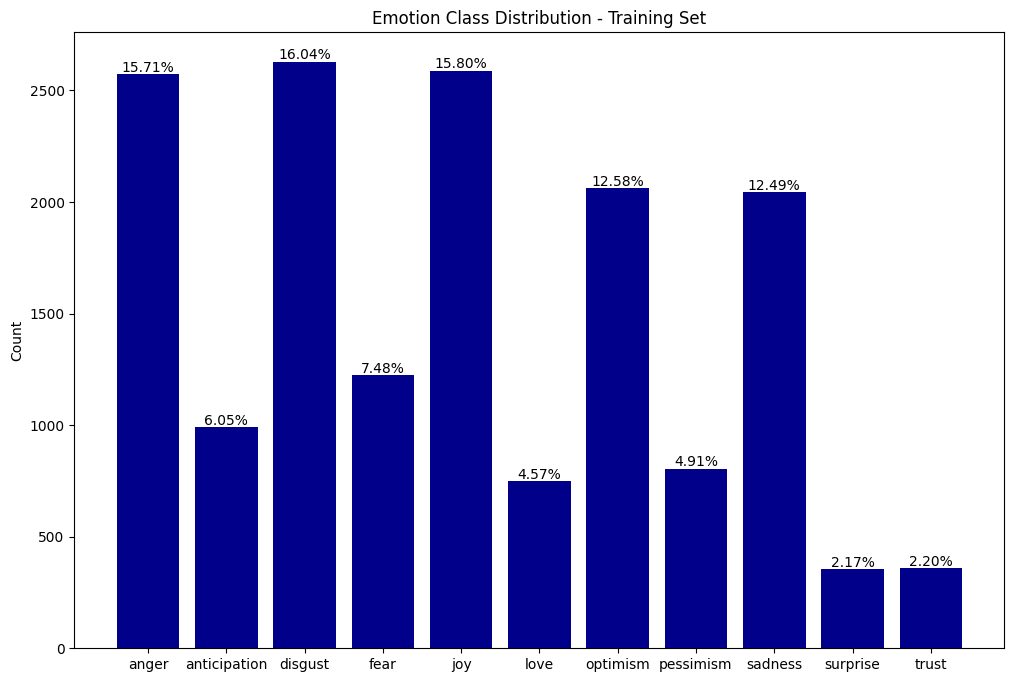

In [ ]:
# plotting of class distribution - Training Set
label_counts_t = train_labels.sum()

# Total label counts
total_counts = label_counts_t.sum()

# percentage calculations
percentages = (label_counts_t/total_counts)*100

# Making a bar plot
plt.figure(figsize = (12,8))
plt.bar(label_counts_t.index, label_counts_t.values, color = 'darkblue')

# Adding labels for the percentages
for i, (count, pct) in enumerate(zip(label_counts_t.values, percentages)):
  plt.text(i, count + 10 , f'{pct:.2f}%',  ha = 'center' )


plt.title('Emotion Class Distribution - Training Set')
plt.ylabel('Count')
plt.show()

In [ ]:
val_labels = val_df[['anger',
                                      'anticipation',
                                             'disgust',
                                             'fear',
                                             'joy',
                                             'love',
                                             'optimism',
                                             'pessimism',
                                             'sadness',
                                             'surprise',
                                             'trust']]

In [ ]:
val_labels.sum()

,0
anger,285
anticipation,111
disgust,292
fear,137
joy,288
love,83
optimism,229
pessimism,90
sadness,227
surprise,40


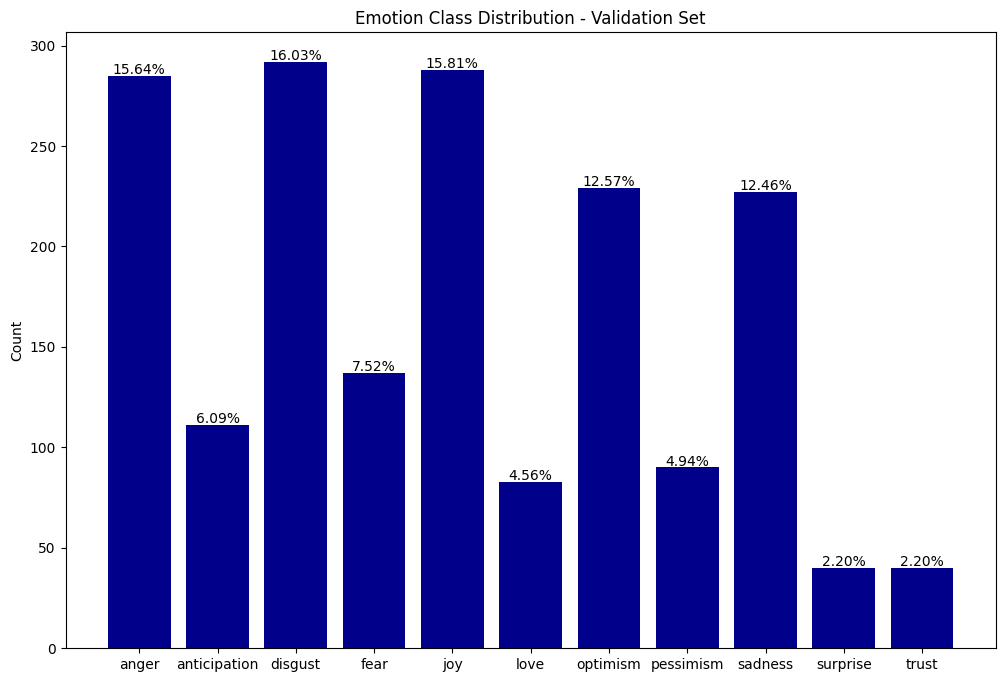

In [ ]:
# plotting of class distribution - Validation Set
label_counts_v = val_labels.sum()

# Total label counts
total_counts = label_counts_v.sum()

# percentage calculations
percentages = (label_counts_v/total_counts)*100

# Making a bar plot
plt.figure(figsize = (12,8))
plt.bar(label_counts_v.index, label_counts_v.values, color = 'Darkblue')

# Adding labels for the percentages
for i, (count, pct) in enumerate(zip(label_counts_v.values, percentages)):
  plt.text(i, count + 1 , f'{pct:.2f}%',  ha = 'center' )


plt.title('Emotion Class Distribution - Validation Set')
plt.ylabel('Count')
plt.show()

### <font color = 'darkblue'>**Noticings about split**

- This time around, since I used 10 splits, the validation data size is about half of what it was from last time.
- Should I notice a significant negative impact on my models performance, I will come back here to change the splits back to 5.

In [ ]:
type(y_train)

numpy.ndarray

In [ ]:
type(X_train)

numpy.ndarray

In [ ]:
# Changing the features to list
X_train = X_train.tolist()
X_val = X_val.tolist()

In [ ]:
X_val[0]

'Do you think humans have the sense for recognizing impending doom? '

## <font color = 'darkblue'>**Final DataSet Creation**

In [ ]:
trainset = Dataset.from_dict(
    {'text':X_train, 'label':y_train}
)

validset = Dataset.from_dict(
    {'text':X_val, 'label':y_val}
)

In [ ]:
trainset

Dataset({
    features: ['text', 'label'],
    num_rows: 6951
})

In [ ]:
validset

Dataset({
    features: ['text', 'label'],
    num_rows: 773
})

In [ ]:
# Compiling the trainset and validset into a dictionary for training
train_val = DatasetDict({'train':trainset, 'valid':validset})

In [ ]:
train_val

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 6951
    })
    valid: Dataset({
        features: ['text', 'label'],
        num_rows: 773
    })
})

In [ ]:
train_val['train']['label'][0] # pulling the first label from the trainset of the dictionary

[0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]

## <font color='darkblue'>**Loading the DistilRoBERTa tokenizer**

### The difference between DistilRoBERTa and BERT:
- **BERT** (Bidirectional Encoder Representations from Transformers) is a transformer-based model that focuses on two key tasks:
  - **Masked Language Modeling**: BERT randomly masks 15% of tokens in the input sequence, and the model learns to predict the masked tokens, which helps it understand context better.
  - **Next Sentence Prediction**: BERT is trained to predict whether two sentences follow each other in a given pair (e.g., "Is sentence A followed by sentence B?").
  - BERT can handle many different tasks, but these two are the main pretraining objectives.

- **DistilRoBERTa** (Distilled RoBERTa):
  - DistilRoBERTa is a more efficient, lightweight version of RoBERTa, trained using knowledge distillation. It keeps most of the language understanding abilities of RoBERTa but in a much smaller and faster model.
  - Like RoBERTa, DistilRoBERTa doesn't use the next sentence prediction task and sticks with masked language modeling for efficiency and performance.
  - The goal is to reduce model size and speed up both training and inference times without sacrificing too much performance, making it a strong option when you need faster responses.

- The key difference between **DistilRoBERTa** and **BERT** is all about efficiency. DistilRoBERTa trades off some of the complexity for speed and size, making it a faster, leaner model while still performing well in masked language tasks.

Info on DistilRoBERTa: [DistilRoBERTa Tokenizer](https://huggingface.co/transformers/model_doc/distilroberta.html)


In [ ]:
# Loading in the tokenizer
checkpoint = 'distilroberta-base'

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

### <font color = 'darkblue'>**Creating the Tokenize Function**

In [ ]:
def tokenize(batch):
  return tokenizer(batch['text'], truncation = True, padding = True, return_tensors='pt')

In [ ]:
tokenized_ds = train_val.map(tokenize, batched = True)
tokenized_ds = tokenized_ds.remove_columns(['text'])

tokenized_ds.set_format(type = 'torch')

Map:   0%|          | 0/6951 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

In [ ]:
tokenized_ds

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 6951
    })
    valid: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 773
    })
})

In [ ]:
tokenized_ds['train'][0]

{'label': tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1]),
 'input_ids': tensor([    0,    17,    48,   771, 17649,    16,    10,   159,  3207,    15,
            10,   936,    47,   189,   393,    33,  2652,  1437, 50141, 37252,
          1755, 11392,     4,  1437,   849, 25331, 38591,   849, 23240,  4128,
           849,   605, 17649,     2,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
             1]),
 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}

#### <font color='darkblue'>**Remapping labels to float**

- In the code below, I call a `map` function that creates a new column `float_label` by converting each label from an integer to a PyTorch float tensor. Afterward, it removes the original `Labels` column (which was of type int) and renames the new `float_label` column back to `Labels`, ensuring that the labels are now in the correct format for training.

In [ ]:
# Remapping labels to float
tokenized_ds = (tokenized_ds.map(lambda x: {'float_label': x['label'].to(torch.float)}, remove_columns=['label'])
                .rename_column('float_label', 'label'))

Map:   0%|          | 0/6951 [00:00<?, ? examples/s]

Map:   0%|          | 0/773 [00:00<?, ? examples/s]

In [ ]:
tokenized_ds['train']['label'][0]

tensor([0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1.])

In [ ]:
tokenized_ds['valid']['label'][0]

tensor([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

# <font color ='darkblue'>**Training the Model**


In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(checkpoint,
                                                           num_labels = 11,
                                                           problem_type ='multi_label_classification')

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
class_names = ['anger',
 'anticipation',
 'disgust',
 'fear',
 'joy',
 'love',
 'optimism',
 'pessimism',
 'sadness',
 'surprise',
 'trust']

In [ ]:
config = AutoConfig.from_pretrained(checkpoint)

id2label = {id_: label_ for id_, label_ in enumerate(class_names)}
label2id = {label_:id_ for id_, label_ in enumerate(class_names)}

config.id2label = id2label
config.label2id = label2id

model.config = config

In [ ]:
model.config

RobertaConfig {
  "_name_or_path": "distilroberta-base",
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "anger",
    "1": "anticipation",
    "2": "disgust",
    "3": "fear",
    "4": "joy",
    "5": "love",
    "6": "optimism",
    "7": "pessimism",
    "8": "sadness",
    "9": "surprise",
    "10": "trust"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "anger": 0,
    "anticipation": 1,
    "disgust": 2,
    "fear": 3,
    "joy": 4,
    "love": 5,
    "optimism": 6,
    "pessimism": 7,
    "sadness": 8,
    "surprise": 9,
    "trust": 10
  },
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 12,
  "num_hidden_layers": 6,
  "pad_token_id": 1,
  "position_embedding_type": "abs

## <font color = 'darkblue'>**Creating the compute_metrics function**

In [ ]:
accuracy = evaluate.load('accuracy', 'multilabel')
f1 = evaluate.load('f1', 'multilabel')
accuracy_flatten = evaluate.load('accuracy')

def compute_metrics(eval_pred):
  logits, labels = eval_pred # pulls out the labels and logits
  logits_tensor = torch.tensor(logits) # Converting the logits to a tensor
  preds = (torch.sigmoid(logits_tensor)> 0.4 ).int().numpy() # if the value is above the 0.4 threshold we predict the class as being present
  # flattens the predictions and labels into 1D format so that the calculation can be made
  accuracy_label = accuracy_flatten.compute(predictions = preds.flatten(), references = labels.flatten())
  # Calculating the predictions vs the references accross entire labels (all predicted labels need to match the reference labels for a doc)
  accuracy_all = accuracy.compute(predictions = preds,references = labels)
  f1_macro = f1.compute(predictions = preds, references = labels, average = 'macro')
  f1_micro = f1.compute(predictions = preds, references = labels, average = 'micro')

  return {
      'f1_macro':f1_macro['f1'],
      'f1_micro': f1_micro['f1'],
      'accuracy_label':accuracy_label['accuracy'],
      'accuracy_all':accuracy_all['accuracy']}

## <font color = 'darkblue'>**Training Arguments**

In [ ]:
# Using the same training arguments as I used in my last model
run_name= 'disilroberta-emotion-exp1'
# Configure training parameters
training_args = TrainingArguments(
    num_train_epochs=3,  # training epochs
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=5e-5,  # Increase learning rate for more aggressive updates
    optim='adamw_torch',  # Optimizer

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    eval_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=50,  # Perform evaluation every 50 training steps for more stable evaluations
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=50,  # Save a model checkpoint every 50 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    metric_for_best_model="eval_f1_macro",  # Continue using F1 Macro as the key metric
    greater_is_better=True,  # A model is 'better' if its F1 Macro score is higher

    # Experiment logging configurations
    logging_strategy='steps',
    logging_steps=50,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name=run_name,  # Experiment name for Weights & Biases
)

In [ ]:
# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

<ipython-input-47-dfcff32096f4>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
%env WANDB_PROJECT = multilabel_distilroberta_emotion

env: WANDB_PROJECT=multilabel_distilroberta_emotion


In [ ]:
# start training
trainer.train()

wandb: Currently logged in as: the-steven-e (the-steven-e-the-university-of-texas-at-dallas). Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss,F1 Macro,F1 Micro,Accuracy Label,Accuracy All
50,0.493200,0.436343,0.227676,0.483175,0.808538,0.165589
100,0.417400,0.386932,0.306859,0.579752,0.828649,0.144890
150,0.393900,0.374171,0.336569,0.586600,0.825121,0.153946
200,0.374300,0.358196,0.401550,0.620792,0.850288,0.217335
250,0.366100,0.343867,0.455782,0.650055,0.851347,0.212160
300,0.348600,0.325530,0.472731,0.665551,0.858991,0.201811
350,0.336000,0.327545,0.488146,0.665542,0.860049,0.218629
400,0.331100,0.323092,0.495507,0.666475,0.863813,0.240621
450,0.326600,0.318250,0.520374,0.683362,0.870634,0.247089
500,0.308000,0.320379,0.486467,0.672501,0.863578,0.228978


TrainOutput(global_step=1305, training_loss=0.3091740783603712, metrics={'train_runtime': 209.6292, 'train_samples_per_second': 99.476, 'train_steps_per_second': 6.225, 'total_flos': 835508423291598.0, 'train_loss': 0.3091740783603712, 'epoch': 3.0})

## <font color = 'darkblue'>**Continuing Training from Best Checkpoint**

- Based on the results of the training process above I want to continue training based on my best checkpoint.
- To do this I will redesignate the training arguments and add epochs to the training process.
- I will be adding a learning rate scheduler as well

In [ ]:
# New training params - extension of the last but with more changes
run_name= 'distilroberta-emotion-exp2'
# Configure training parameters
training_args = TrainingArguments(
    num_train_epochs=5,  # increased the number of epochs
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    learning_rate=5e-5,
    optim='adamw_torch',

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),
    eval_strategy='steps',
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    load_best_model_at_end=True,
    save_total_limit=2,
    metric_for_best_model="eval_f1_macro",
    greater_is_better=True,
    lr_scheduler_type = 'linear',
    warmup_steps = 300, # Warmup in 300 steps



    # Experiment logging configurations
    logging_strategy='steps',
    logging_steps=100,
    report_to='wandb',
    run_name=run_name,
)

In [ ]:
# initialize trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["valid"],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

<ipython-input-52-dfcff32096f4>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
%env WANDB_PROJECT = multilabel_distilroberta_emotion_checkpoint1

env: WANDB_PROJECT=multilabel_distilroberta_emotion_checkpoint1


In [ ]:
best_checkpoint_1 = model_folder/'checkpoint-1050'

In [ ]:
trainer.train(resume_from_checkpoint = best_checkpoint_1)

/usr/local/lib/python3.10/dist-packages/transformers/trainer.py:3347: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  torch.load(os.path.join(checkpoint, OPTIMIZER_NAME), map_

Step,Training Loss,Validation Loss,F1 Macro,F1 Micro,Accuracy Label,Accuracy All
1100,0.261800,0.308656,0.537451,0.686424,0.869340,0.248383
1150,0.266300,0.301616,0.552550,0.693635,0.872633,0.248383
1200,0.252600,0.310522,0.555749,0.697946,0.872045,0.258732
1250,0.261200,0.310267,0.575285,0.684462,0.867929,0.238034
1300,0.266900,0.299023,0.584018,0.707565,0.874985,0.253558
1350,0.232000,0.304871,0.572724,0.703411,0.872163,0.250970
1400,0.235200,0.301219,0.562231,0.700226,0.875338,0.261320
1450,0.234800,0.306404,0.567826,0.694183,0.870163,0.247089
1500,0.242600,0.300472,0.569887,0.700584,0.873339,0.247089
1550,0.241000,0.303102,0.577775,0.704095,0.871692,0.250970


TrainOutput(global_step=2175, training_loss=0.11967899739057168, metrics={'train_runtime': 173.9542, 'train_samples_per_second': 199.794, 'train_steps_per_second': 12.503, 'total_flos': 1391030786868282.0, 'train_loss': 0.11967899739057168, 'epoch': 5.0})

<font color = 'darkblue'>***Evaluating on the Validation Data***

In [ ]:
eval_results = trainer.evaluate(tokenized_ds['valid'])

- This has been the best performing model so far.
- A f1 macro score of 0.58 indicates that our model is doing better than a random guess across all classes.
- The evaluation accuracy is a difficult task to crack when doing a multilabel classification task but this model is correctly predicting all of the classes 25% of the documents.

In [ ]:
eval_results

{'eval_loss': 0.2990231215953827,
 'eval_f1_macro': 0.5840184268018324,
 'eval_f1_micro': 0.7075653370013755,
 'eval_accuracy_label': 0.8749852993061272,
 'eval_accuracy_all': 0.2535575679172057,
 'eval_runtime': 0.7825,
 'eval_samples_per_second': 987.893,
 'eval_steps_per_second': 62.622,
 'epoch': 5.0}

In [ ]:
wandb.log({"eval_f1_macro": eval_results["eval_f1_macro"], "eval_loss": eval_results["eval_loss"], "eval_accuracy": eval_results["eval_accuracy_all"]})

<font color = 'darkblue'>***Simple Confusion Matrix***

In [ ]:
valid_output = trainer.predict(tokenized_ds["valid"])

In [ ]:
valid_preds = np.array((valid_output.predictions > 0)).astype(int)
valid_labels = np.array((valid_output.label_ids.astype(int)))

In [ ]:
mcm = multilabel_confusion_matrix(valid_preds, valid_labels)
print(mcm)

[[[437  54]
  [ 51 231]]

 [[634  76]
  [ 28  35]]

 [[415  85]
  [ 66 207]]

 [[595  29]
  [ 41 108]]

 [[444  60]
  [ 41 228]]

 [[664  39]
  [ 26  44]]

 [[474  49]
  [ 70 180]]

 [[655  63]
  [ 28  27]]

 [[501 108]
  [ 45 119]]

 [[730  32]
  [  3   8]]

 [[733  40]
  [  0   0]]]


In [ ]:
def multilabel_evaluation(y_true, y_pred, class_names=None, figsize=(12, 8)):
    """
    Generate comprehensive evaluation visualizations for multilabel classification results.

    Parameters:
    -----------
    y_true : array-like
        True labels (n_samples, n_classes)
    y_pred : array-like
        Predicted labels (n_samples, n_classes)
    class_names : list, optional
        List of class names for better visualization
    figsize : tuple, optional
        Base figure size for plots (width, height)

    Returns:
    --------
    dict
        Dictionary containing the computed metrics for each class
    """
    # Validate inputs
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    if y_true.shape != y_pred.shape:
        raise ValueError("y_true and y_pred must have the same shape")

    # Generate class names if not provided
    if class_names is None:
        class_names = [f'Class {i}' for i in range(y_true.shape[1])]

    # Calculate confusion matrices
    mcm = multilabel_confusion_matrix(y_true, y_pred)

    # 1. Individual Confusion Matrix Heatmaps
    n_classes = len(class_names)
    n_cols = min(3, n_classes)
    n_rows = (n_classes + n_cols - 1) // n_cols

    plt.figure(figsize=(figsize[0], figsize[1] * n_rows/2))
    for idx, matrix in enumerate(mcm):
        plt.subplot(n_rows, n_cols, idx + 1)
        sns.heatmap(matrix, annot=True, fmt='g', cmap='Blues',
                    xticklabels=['Pred Neg', 'Pred Pos'],
                    yticklabels=['True Neg', 'True Pos'])
        plt.title(f'{class_names[idx]}')
    plt.tight_layout()
    plt.show()

    # 2. Calculate and plot aggregate metrics
    metrics = {
        'Precision': precision_score(y_true, y_pred, average=None),
        'Recall': recall_score(y_true, y_pred, average=None),
        'F1-Score': f1_score(y_true, y_pred, average=None)
    }

    metrics_df = pd.DataFrame(metrics, index=class_names)

    # Metrics Heatmap
    plt.figure(figsize=(figsize[0]/1.5, figsize[1]/1.5))
    sns.heatmap(metrics_df, annot=True, fmt='.3f', cmap='Blues')
    plt.title('Performance Metrics by Class')
    plt.tight_layout()
    plt.show()

    # 3. Metrics Histogram
    plt.figure(figsize=(figsize[0], figsize[1]/1.5))
    metrics_df.plot(kind='bar', width=0.8)
    plt.xlabel('Classes')
    plt.ylabel('Score')
    plt.title('Precision, Recall, and F1-Score by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 4. Calculate and return summary statistics
    summary_stats = {
        'macro_avg': {
            'precision': np.mean(metrics['Precision']),
            'recall': np.mean(metrics['Recall']),
            'f1': np.mean(metrics['F1-Score'])
        },
        'per_class': metrics_df.to_dict()
    }

    return summary_stats

# <font color = 'Darkblue'>**Validation Analysis**

- This is my best performing model as of yet because it has been able to pick up many of the patterns of the imbalanced classes.
- The top performing classes are anger and joy, which are two of the largest classes in the dataset.
  - Both anger and joy have f1 scores above 0.81, this is a significant improvement even over the last model where the f1 scores were in the high 70's
- Another significant observation is that the model actually was able to accurately predict the labels of one of the most underrepresented classes: surprise.
  - This is significant because it points to my models ability to deal with class imbalances and further drives up f1 score.
- There is still room to grow though, because my model was unable to accurately predict any of the positives of the trust class.


***Now for some inference***

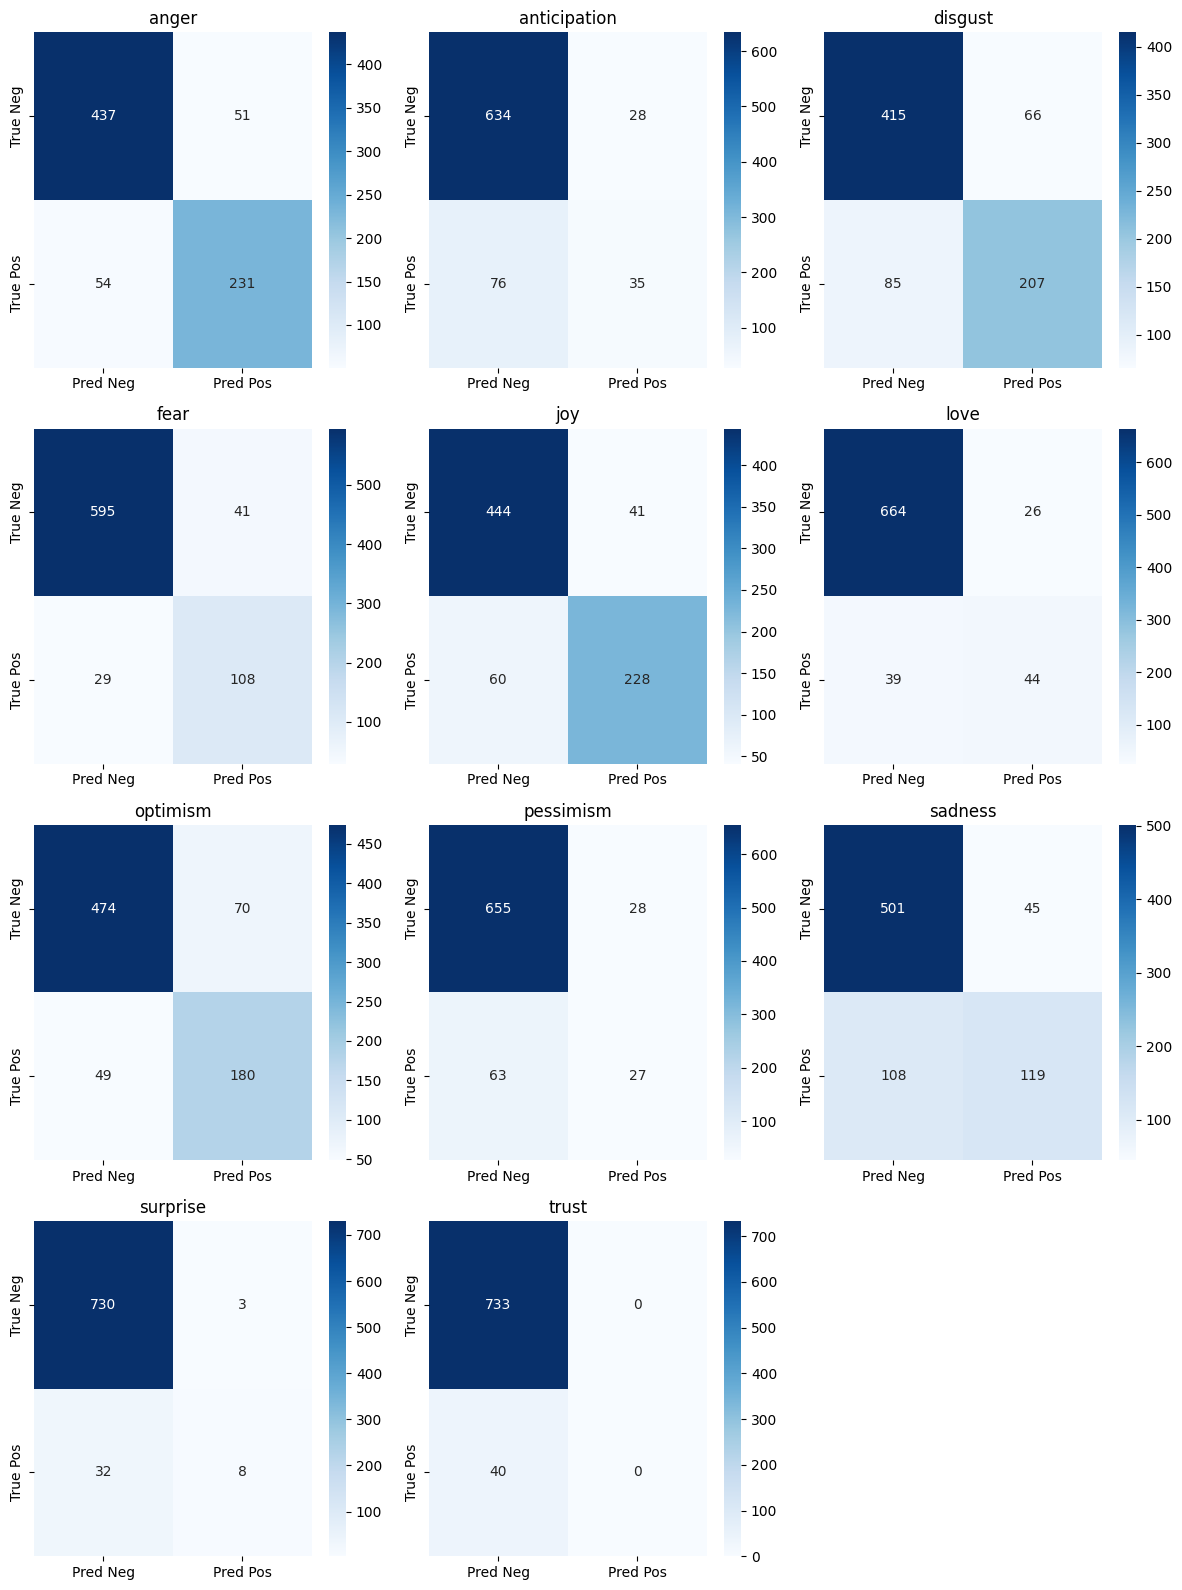

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


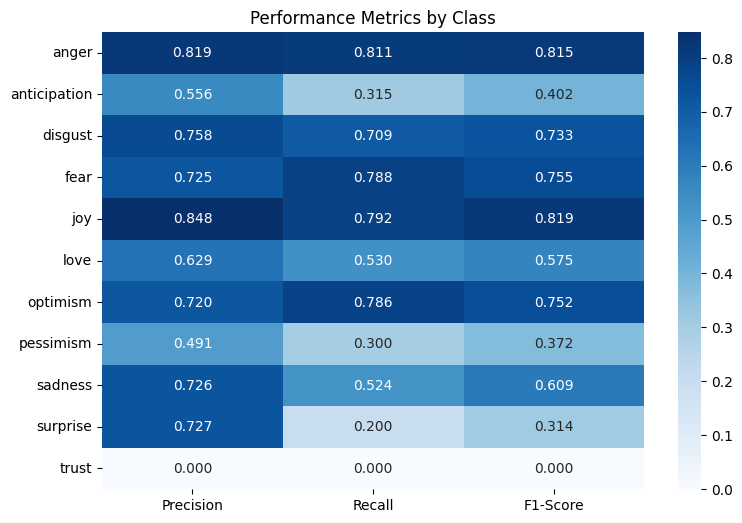

<Figure size 1200x533.333 with 0 Axes>

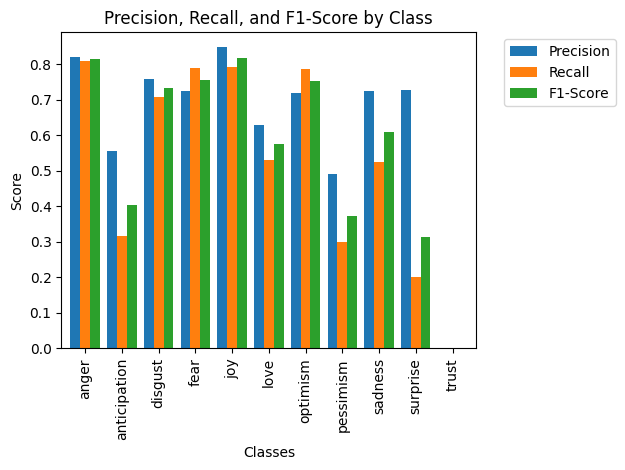

{'macro_avg': {'precision': 0.6361568282460102,
  'recall': 0.5231917575395136,
  'f1': 0.5586670303505088},
 'per_class': {'Precision': {'anger': 0.8191489361702128,
   'anticipation': 0.5555555555555556,
   'disgust': 0.7582417582417582,
   'fear': 0.7248322147651006,
   'joy': 0.8475836431226765,
   'love': 0.6285714285714286,
   'optimism': 0.72,
   'pessimism': 0.4909090909090909,
   'sadness': 0.725609756097561,
   'surprise': 0.7272727272727273,
   'trust': 0.0},
  'Recall': {'anger': 0.8105263157894737,
   'anticipation': 0.3153153153153153,
   'disgust': 0.708904109589041,
   'fear': 0.7883211678832117,
   'joy': 0.7916666666666666,
   'love': 0.5301204819277109,
   'optimism': 0.7860262008733624,
   'pessimism': 0.3,
   'sadness': 0.5242290748898678,
   'surprise': 0.2,
   'trust': 0.0},
  'F1-Score': {'anger': 0.8148148148148148,
   'anticipation': 0.40229885057471265,
   'disgust': 0.7327433628318584,
   'fear': 0.7552447552447552,
   'joy': 0.8186714542190305,
   'love': 0

In [ ]:
evaluation = multilabel_evaluation(y_true = valid_labels, y_pred = valid_preds, class_names = class_names, figsize = (12,8))
evaluation

# <font color = 'darkblue'>**Model Inferencing**

In [ ]:
# After training, let us check the best checkpoint
# We need this for Inference
best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
print(f"The best model was saved at step {best_model_checkpoint_step}.")

The best model was saved at step 1300.


In [ ]:
checkpoint = str(model_folder/f'checkpoint-{best_model_checkpoint_step}')

custom_pipeline = pipeline(
    task = 'text-classification',
    model = checkpoint,
    tokenizer = checkpoint,
    device = 0,
    return_all_scores = True
)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [ ]:
# Loading in the testing data
test_ds = joblib.load(data_folder/'X_test_cleaned.pkl')

In [ ]:
# View Test
test_df = pd.DataFrame(test_ds).T
test_df.rename(columns ={0:'text', 1:'label'}, inplace = True)
print(test_df.head())
print('-'*30)
print(test_df.shape)
print('There are no Labels for the entire test set')

                                                text  \
0  @Adnan__786__ @AsYouNotWish Dont worry Indian ...   
1  Academy of Sciences, eschews the normally sobe...   
2                  I blew that opportunity -__- #mad   
3             This time in 2 weeks I will be 30... 😥   
4  #Deppression is real. Partners w/ #depressed p...   

                                               label  
0  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
1  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
2  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
3  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
4  [NONE, NONE, NONE, NONE, NONE, NONE, NONE, NON...  
------------------------------
(3259, 2)
There are no Labels for the entire test set


In [ ]:
sample = test_df['text'][0]

preds = custom_pipeline(sample)
preds

[[{'label': 'anger', 'score': 0.8863304257392883},
  {'label': 'anticipation', 'score': 0.057072024792432785},
  {'label': 'disgust', 'score': 0.850921094417572},
  {'label': 'fear', 'score': 0.8976728916168213},
  {'label': 'joy', 'score': 0.011702523566782475},
  {'label': 'love', 'score': 0.006290670949965715},
  {'label': 'optimism', 'score': 0.026561299338936806},
  {'label': 'pessimism', 'score': 0.09714937955141068},
  {'label': 'sadness', 'score': 0.15462689101696014},
  {'label': 'surprise', 'score': 0.016316454857587814},
  {'label': 'trust', 'score': 0.012873868457973003}]]

In [ ]:
def get_labels(pipeline_output, threshold = 0.4):

  positive_labels = []

  for pred_set in pipeline_output:

    # getting the labels where the score is at or above the threshold
    sample_positives = [pred['label'] for pred in pred_set if pred['score']>=threshold]

    positive_labels.append(sample_positives)

  return positive_labels

In [ ]:
results = get_labels(preds, threshold = 0.4)
results

[['anger', 'disgust', 'fear']]

<font color = 'darkblue'>***Important noticing***
- With this model we predicted 3 classes instead of the 2 from distilbert.


# <font color = 'Darkblue'>**Final Inferencing**

- In this step I will be doing inferencing on the test set with no labels and making a submission to the Kaggle Competition.
- Based on my observations so far, this should be the best model of the competition.
- I will be using my premade function to attach the labels and make a new csv.
- At the end of this notebook I will be writing a Final Report of the model.

In [ ]:
def get_predictions_from_pipeline(pipeline_output, model, df_test_ids, threshold = 0.4):
  """
  This function will process the pipeline output, apply the threshold and get predictions for the test dataset
  and generate a final DataFrame containing the test ID's and predicted labels.

  Parameters:
  - pipeline_output: The output from the custom pipeline (containing the scores)
  - model: The model used for generating the pipeline output (to get the id2labels)
  - df_test_ids: A dataframe containing the test ID's
  - threshold: The prediction threshold for making a prediction (default is 0.4)

  Returns:
  - df_pred_final: A pandas dataframe with the test ID's and their corresponding label predictions in binary format
  - positive_labels_list: a list of positive labels for each instance to compare results.
  """

  # 1. Prepare lists for appending results
  positive_labels_list = []
  binary_predictions = []

  # 2. Process the lists to store the binary preditions and positive labels

  for pred_set in pipeline_output:
    # Getting the positive labels where the score is at or above the threshold
    sample_positives = [pred['label'] for pred in pred_set if pred['score']>= threshold]
    positive_labels_list.append(sample_positives)

    # Getting the binary predictions ( 1 if >= threshold, else 0)
    binary_preds = [1 if pred['score'] >= threshold else 0 for pred in pred_set]
    binary_predictions.append(binary_preds)

  # 3. Convert the binary predictions to a dataframe
  # Map the model config labels
  class_labels = [model.config.id2label[i] for i in range(len(model.config.id2label))]

  df_predictions = pd.DataFrame(binary_predictions, columns = class_labels)

  df_pred_final = pd.concat([df_test_ids.reset_index(drop = True), df_predictions], axis = 1 )

  # Setting the index of the final df to be the ID column
  df_pred_final = df_pred_final.set_index('ID')


  return df_pred_final, positive_labels_list


<font color = 'darkblue'>***Test set id column values from other notebook***

In [ ]:
test_ids = joblib.load(data_folder/'test_ids.pkl')
test_ids.head()

,ID
0,2018-01559
1,2018-03739
2,2018-00385
3,2018-03001
4,2018-01988


<font color = 'darkblue'>***Prepping the test_df to make predictions***

In [ ]:
test_ds = test_df.drop(columns = {'label'}) # dropping the missing labels from the test dataset

In [ ]:
test_ds = Dataset.from_pandas(test_ds)

In [ ]:
test_ds['text'][0:3]

['@Adnan__786__ @AsYouNotWish Dont worry Indian army is on its ways to dispatch all Terrorists to Hell',
 'Academy of Sciences, eschews the normally sober tone of scientific papers and calls the massive loss of wildlife a “biological annihilation',
 'I blew that opportunity -__- #mad']

In [ ]:
# Input for my function
pipeline_output = custom_pipeline(test_ds['text'][:]) # running the prediction pipeline on all of the text

In [ ]:
# Model and tokenizer being set to my checkpoints
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
# Make predictions
df_pred_final, positive_labels_list = get_predictions_from_pipeline(pipeline_output = pipeline_output,
                                                                    model = model,
                                                                    df_test_ids = test_ids, threshold = 0.4)

In [ ]:
df_pred_final.sum()

,0
anger,1148
anticipation,294
disgust,1162
fear,556
joy,1482
love,521
optimism,1388
pessimism,331
sadness,888
surprise,50


In [ ]:
df_pred_final.shape

(3259, 11)

In [ ]:
df_pred_final.to_csv(base_folder/'final_predictions_distilroberta.csv', )